## Vanitas Object Recognition Demo


In [1]:
import os

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

import numpy as np

from mrcnn import visualize, utils
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.visualize import display_images
from vanitas_utils import VanitasDataset, VanitasConfig

## Dataset

In [2]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = VanitasDataset()
VANITAS_DIR = os.path.join(ROOT_DIR, "data/vanitas_json")
dataset.load_vanitas(VANITAS_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 50
Class Count: 35
  0. BG                                                
  1. Skull                                             
  2. Hourglass                                         
  3. Globe                                             
  4. Coins                                             
  5. Butterfly                                         
  6. Flowers                                           
  7. Watch                                             
  8. Dice                                              
  9. Fruit                                             
 10. violin                                            
 11. Lute                                              
 12. Flute                                             
 13. Candle                                            
 14. Inkstand                                          
 15. Music                                             
 16. Bubble                                            
 17. Lamp       

## Load and display random samples

Load and display random samples together with the masks.

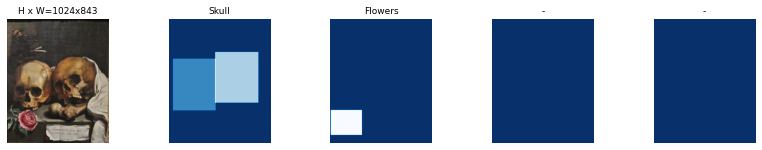

[6 1 1]


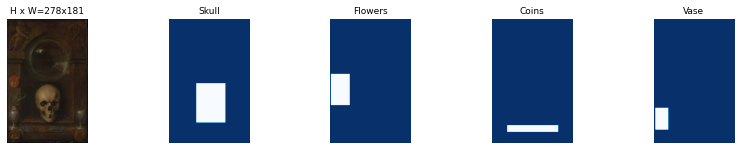

[ 1  6 21  4]


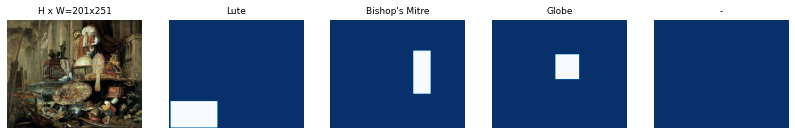

[24  3 11]


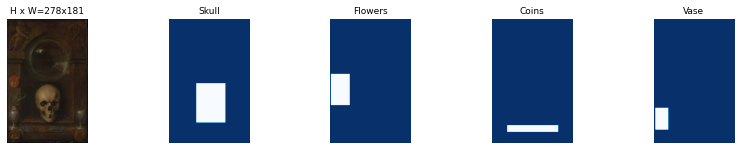

[ 1  6 21  4]


In [3]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    print(class_ids)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the update masks rather than computing bounding box transformation for each type of image transformation.

image_id  15 /Users/ryan_rhys/ml_physics/fine_art_asssociations_meanings/data/vanitas_json/train/cdf52ee5d5.jpg
image                    shape: (267, 189, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (267, 189, 7)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (7,)                  min:    1.00000  max:   21.00000  int32
bbox                     shape: (7, 4)                min:    5.00000  max:  233.00000  int32


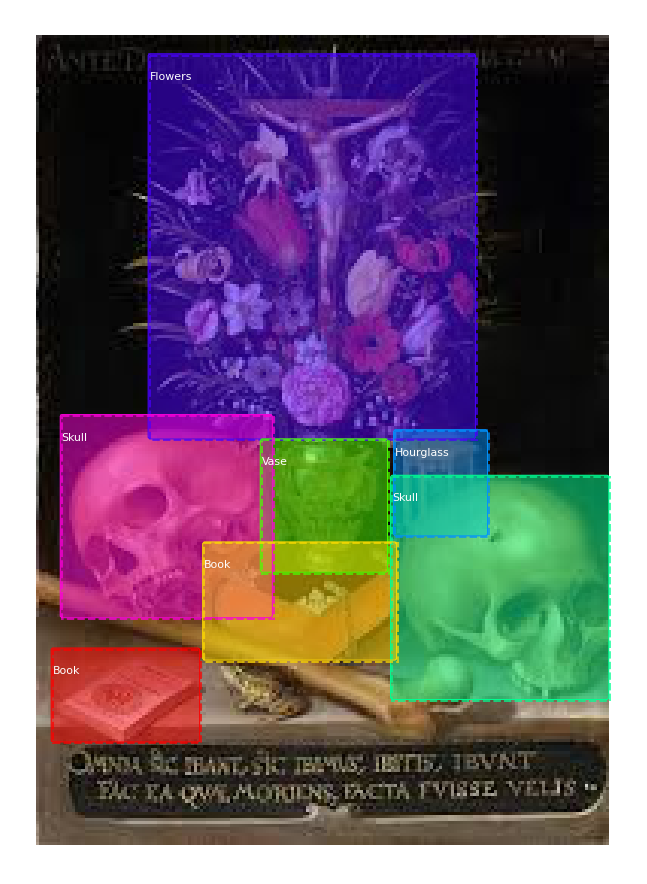

In [4]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  41 /Users/ryan_rhys/ml_physics/fine_art_asssociations_meanings/data/vanitas_json/train/afe8841a25.jpg
Original shape:  (1113, 1000, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 8)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (8,)                  min:    1.00000  max:   22.00000  int32
bbox                     shape: (8, 4)                min:   99.00000  max:  972.00000  int32


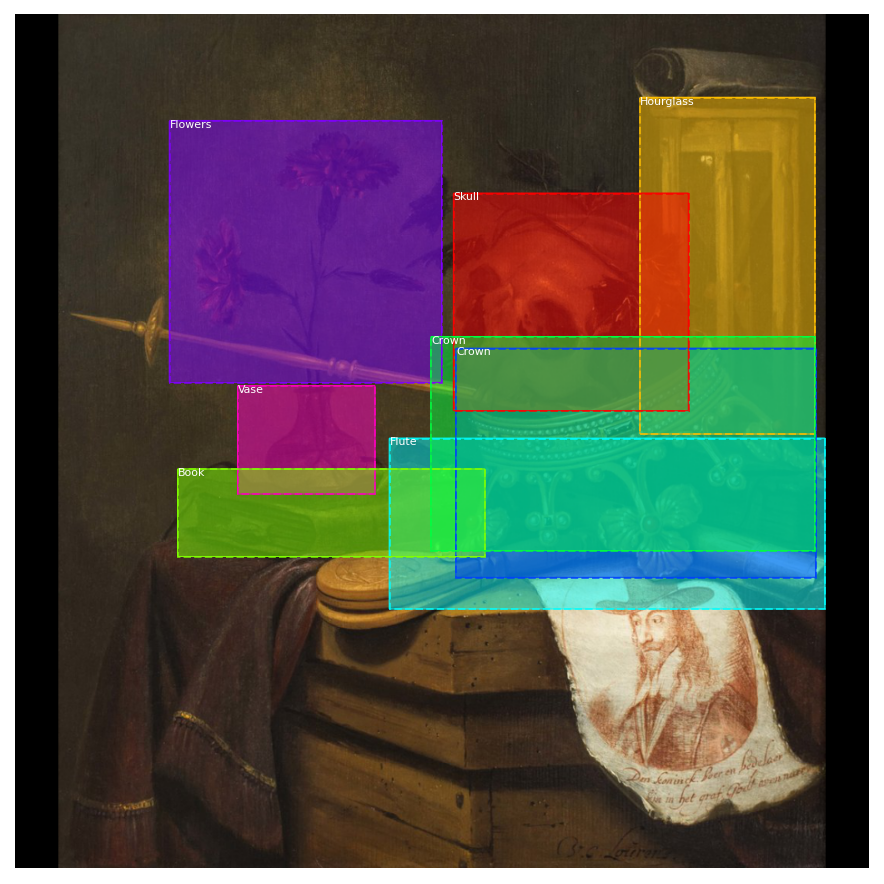

In [5]:
# Load random image and mask.

image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

config = VanitasConfig()

# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)

mask = utils.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone.

To improve training speed, we optimize masks by:

* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (47,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (4,)                  min:    1.00000  max:   13.00000  int32
bbox                     shape: (4, 4)                min:  166.00000  max:  846.00000  int32
mask                     shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


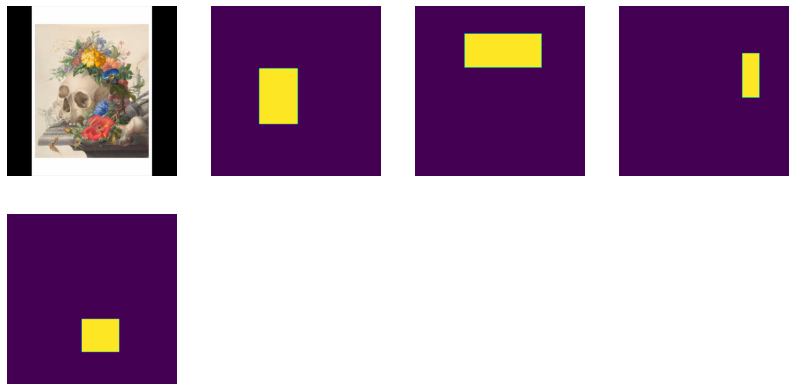

In [6]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

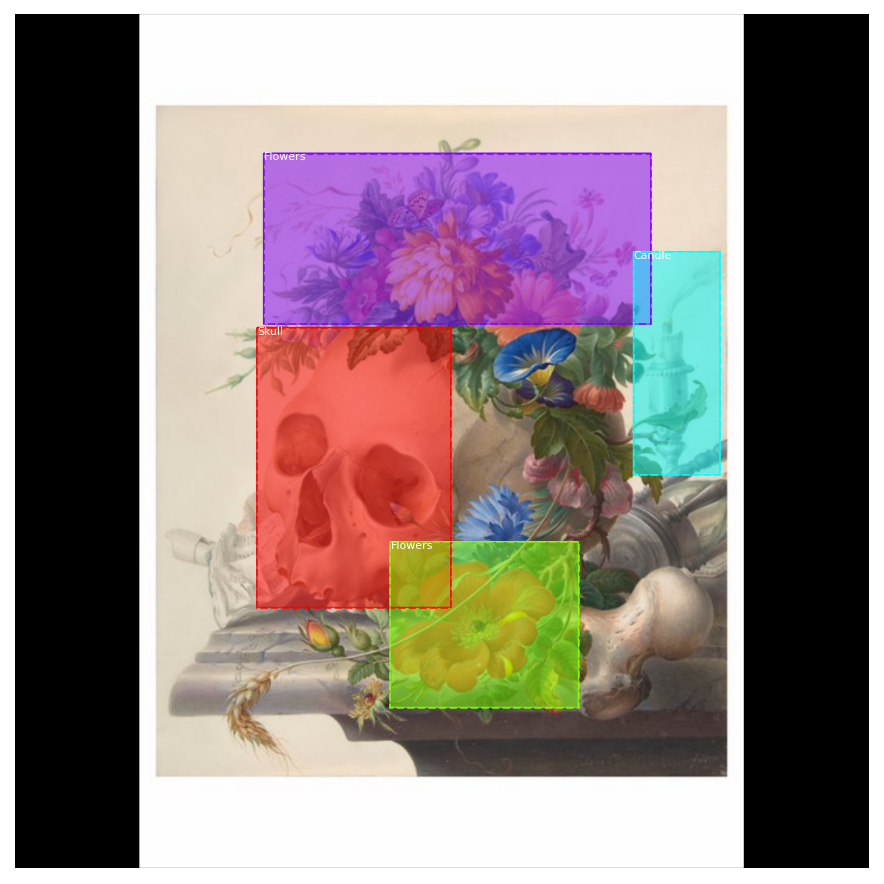

In [7]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


/Users/ryan_rhys/opt/miniconda3/envs/ai_art/lib/python3.8/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


mask                     shape: (56, 56, 4)           min:    1.00000  max:    1.00000  bool


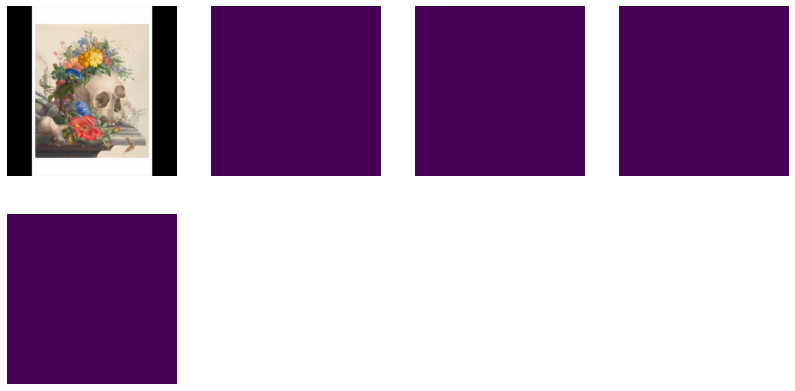

In [8]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

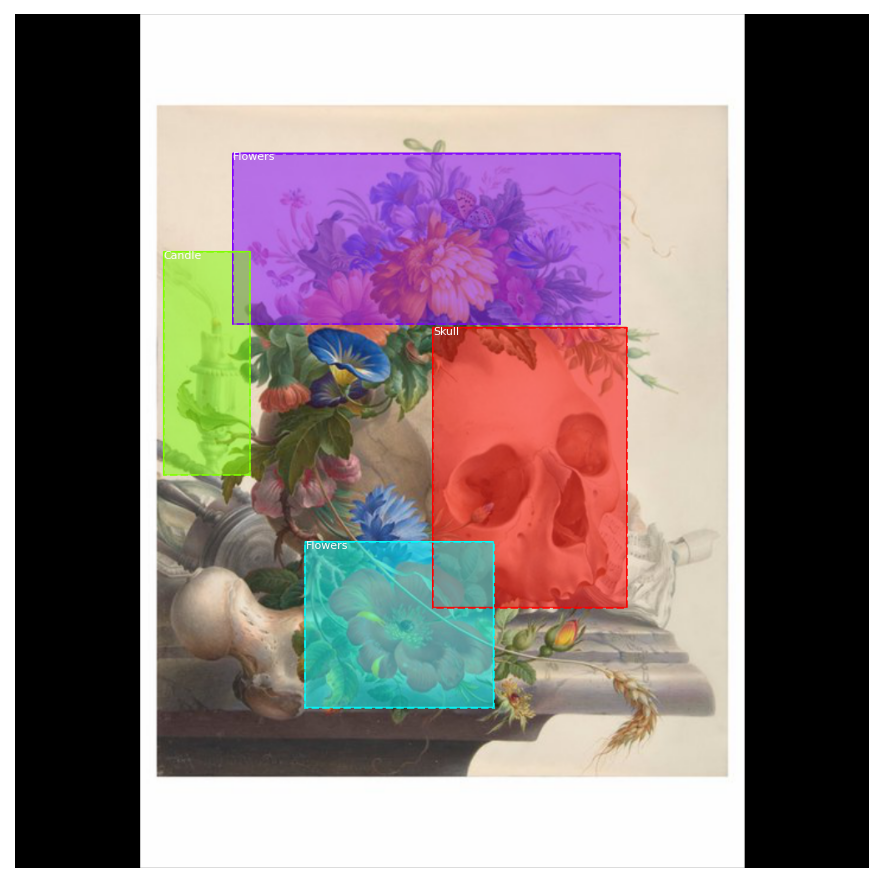

In [9]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchor

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

__Anchor Stride:__ In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (2562563). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.

In [10]:

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768
